In [128]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

In [129]:
def Vpot(x):
    return (x ** 2 - 2.5) * x ** 2
    # return 0.5*x**2


def Psi(x, mu, sigma):
    wavefunction = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    wavefunction += np.exp(-((x + mu) ** 2) / (2 * sigma ** 2))
    return wavefunction


def prob(x, a, mu, sigma):
    return a * Psi(x, mu, sigma) ** 2

# Variational Monte Carlo

**Goal:** Using the variational principle, find a good approximation of the true ground state wavefunction in the assigned potential: 

$$
V(x) = x^4 - \frac{5}{2}x^2
$$

**Method:** 
1. Choose an appropriate parametrized trial wavefunction: 

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

2. Using the Metropolis algorithm, calculate the energy of this trial state. 

$$
\langle H \rangle = \frac{\int dx \, \psi^* \, \hat{H} \, \psi}{\int dx \, |\psi|^2 }  = \int dx \, p(x) \, E_{loc}(x) \\
p(r) = \frac{|\psi|^2 }{\int dx \, |\psi|^2 }, \quad E_{loc}(x) = \frac{\hat{H} \psi}{\psi}
$$

3. Explore the parameter space to find the lowest energy possible. The lower the energy, the closer our trial wavefunction is to the true ground state.

**Implementation:**

Reading parameters from `input.dat`, I took 10000 steps in 100 blocks using the Metropolis algorithm with a Gaussian kernel with $\sigma = 1.8$. Every `iprint` steps I print a position in order to make a histogram 

### Wavefunction Sampling

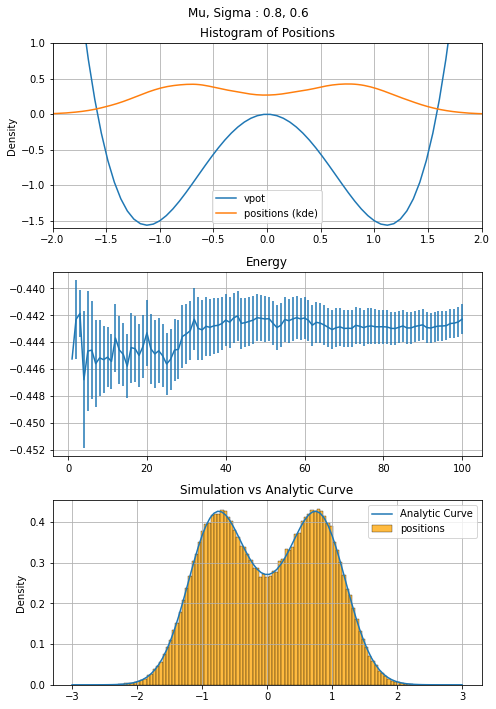

In [130]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10))

pos = np.loadtxt("./data/psi_star/positions.dat", usecols=(1))
blocks, avg, err = np.loadtxt("./data/psi_star/energy.dat", usecols=(0, 2, 3), unpack=True)

mu = 0.8
sig = 0.6
plt.suptitle("Mu, Sigma : " + str(mu) + ", " + str(sig))

x = np.linspace(-3, 3, 100)
sns.lineplot(x=x, y=Vpot(x), ax=ax[0], label="vpot")
sns.kdeplot(pos, ax=ax[0], label="positions (kde)")
ax[0].title.set_text("Histogram of Positions")
ax[0].set_ylim(-1.6, 1)
ax[0].set_xlim(-2.0, 2.0)
ax[0].grid()
ax[0].legend()
ax[1].title.set_text("Energy")
ax[1].errorbar(blocks, avg, yerr=err)
ax[1].grid()

# sns.kdeplot(pos, ax=ax[2], label="positions") # kernel density estimate
sns.histplot(pos, ax=ax[2], label="positions", stat="density", color="orange")
sns.lineplot(x=x, y=prob(x, 0.4, 0.8, 0.6), ax=ax[2], label="Analytic Curve")
ax[2].grid()
ax[2].title.set_text("Simulation vs Analytic Curve")

plt.tight_layout()
plt.show()

**Figure: Trial wavefunction and its energy.** Here I show the wavefunction I found (top), along with its energy (middle). I also compare the histogram of positions with the analytic curve -- the sum of two gaussians (bottom).

### Diagonalization vs Variational Monte Carlo

Ground state energy:  -0.46046587969271535
MC trial state energy:  -0.442283


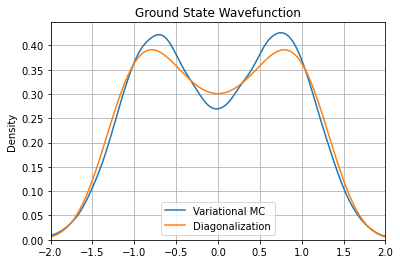

In [6]:
hbar = 1
m = 1
a = 10
N = 1000  # number of iterations
x = np.linspace(-a / 2, a / 2, N)
dx = x[1] - x[0]  # the step size
V = Vpot(x)
CDiff = np.diag(np.ones(N - 1), -1) - 2 * np.diag(np.ones(N), 0) + np.diag(np.ones(N - 1), 1)
H = (-(hbar ** 2) * CDiff) / (2 * m * dx ** 2) + np.diag(V)
E, psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

print("Ground state energy: ", E[0])
print("MC trial state energy: ", avg[len(avg) - 1])
sns.kdeplot(pos, label="Variational MC")
sns.lineplot(x=x, y=psi[0] ** 2, label="Diagonalization")
plt.grid()
plt.title("Ground State Wavefunction")
plt.xlim(-2, 2)
plt.show()

**Figure: Optimized trial wavefunction and "true" ground state.** Here I show the ground state calculated with linear-algebric methods and the one I found using Variational Monte Carlo. The two seem to be as close as possible without coinciding perfectly, indicating that the true ground state is not actually a sum of two gaussians. 

# PIGS

Use the PIMC/PIGS code we have provided to study the same 1D quantum system. Use the PIGS algorithm ($T=0$) to project

1. a constant trial wave function, $\Psi_T(x)=1$
2. using $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ with the variational parameters you have optimized.

Compare your results with those obtained with your VMC code. By using $\Psi_T^{\sigma,\mu}(x)$, how much can you reduce the imaginary time propagation with respect to the first case?

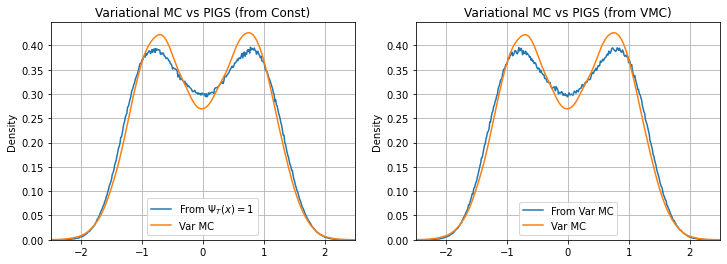

In [77]:
pos_const = np.loadtxt("./data/PIGS/const_probability.dat", usecols=(1))
pos_var = np.loadtxt("./data/PIGS/var_probability.dat", usecols=(1))
pos = np.loadtxt("./data/psi_star/positions.dat", usecols=(1))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
# plt.suptitle("Variational MC vs PIGS")

sns.lineplot(x=np.linspace(-2.5, 2.5, 400), ax=ax[0], y=pos_const, label=r"From $\Psi_T(x)=1$")  # PIGS
sns.lineplot(x=np.linspace(-2.5, 2.5, 400), ax=ax[1], y=pos_var, label="From Var MC")  # PIGS
# sns.lineplot(x=np.linspace(-a / 2, a / 2, N), ax= ax[0], y=psi[0] ** 2, label="Diagonalization")  # Numerical
sns.kdeplot(pos, ax=ax[0], label="Var MC")  # VARMC
sns.kdeplot(pos, ax=ax[1], label="Var MC")  # VARMC

ax[0].title.set_text("Variational MC vs PIGS (from Const)")
ax[0].grid(True)
ax[0].set_xlim(-2.5, 2.5)
ax[0].legend()

ax[1].title.set_text("Variational MC vs PIGS (from VMC)")
ax[1].grid(True)
ax[1].set_xlim(-2.5, 2.5)
ax[1].legend()

plt.show()

**Figure: Ground state found through Variational Monte Carlo compared with ground state found through PIGS.** The graphs are nearly identical except for the fact that one PIGS simulation started with a constant trial wavefunction (left) while the other started with the wavefunction obtained through Variational Monte Carlo.

In [122]:
def plot_pos_hist(GS, STATE, X, LABEL, ax=None):
    
    if ax==None:
        ax = plt.gca()
    sns.lineplot(x=X, ax=ax, y=STATE, label=LABEL) 
    sns.lineplot(x=np.linspace(-2.5, 2.5, 400), ax=ax, y=GS, label="gs") 
    ax.title.set_text(LABEL)
    ax.grid(True)
    ax.set_xlim(-2.5, 2.5)

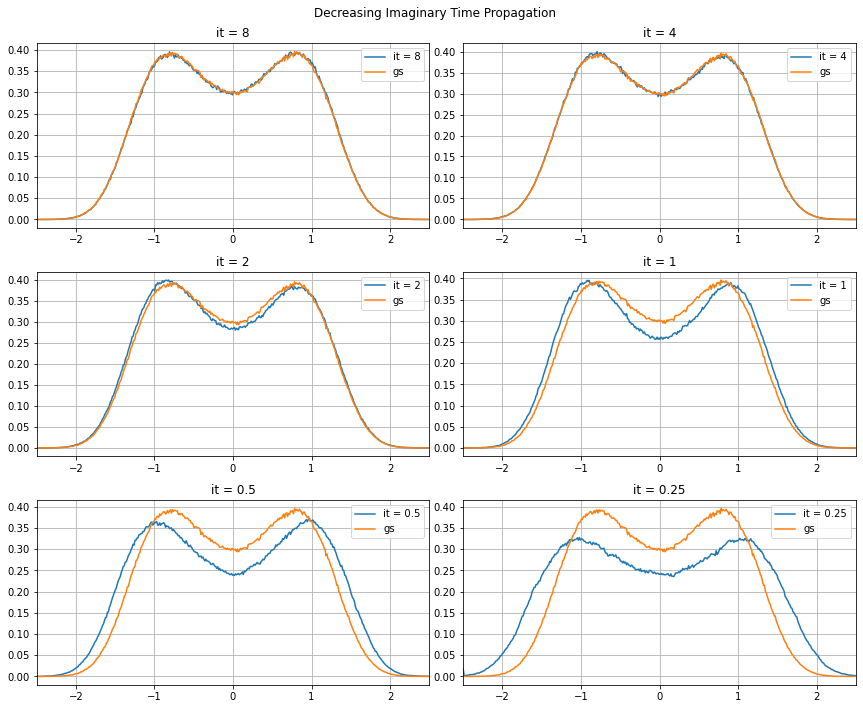

In [126]:
pos_8 = np.loadtxt("./data/PIGS/var_probability.dat", usecols=(1))
pos_4 = np.loadtxt("./data/PIGS/probability_4.dat", usecols=(1))
pos_2 = np.loadtxt("./data/PIGS/probability_2.dat", usecols=(1))
pos_1 = np.loadtxt("./data/PIGS/probability_1.dat", usecols=(1))
pos_05 = np.loadtxt("./data/PIGS/probability_05.dat", usecols=(1))
pos_025 = np.loadtxt("./data/PIGS/probability_025.dat", usecols=(1))
pos_00 = np.loadtxt("./data/probability.00", usecols=(1))

pos_VMC = np.loadtxt("./data/psi_star/positions.dat", usecols=(1))


fig, ax = plt.subplots(3, 2, figsize=(12, 10))
plt.suptitle("Decreasing Imaginary Time Propagation")

x = np.linspace(-2.5, 2.5, 400)

plot_pos_hist(pos_00, pos_8, x, "it = 8", ax=ax[0,0])
plot_pos_hist(pos_00, pos_4, x, "it = 4", ax=ax[0,1])
plot_pos_hist(pos_00, pos_2, x, "it = 2", ax=ax[1,0])
plot_pos_hist(pos_00, pos_1, x, "it = 1", ax=ax[1,1])
plot_pos_hist(pos_00, pos_05, x, "it = 0.5", ax=ax[2,0])
plot_pos_hist(pos_00, pos_025, x, "it = 0.25", ax=ax[2,1])

# sns.kdeplot(pos, ax=ax[2,0], label="VMC")  # VARMC
# ax[2,0].legend()
# sns.kdeplot(pos, ax=ax[2,1], label="VMC")  # VARMC
# ax[2,1].legend()

plt.tight_layout()
plt.show()

**Figure: Decreasing imaginary time propagation on PIGS algorithm when starting with VMC wavefunction.** Here I've tested the limits of the algorithm by decreasing imaginary time propagation.

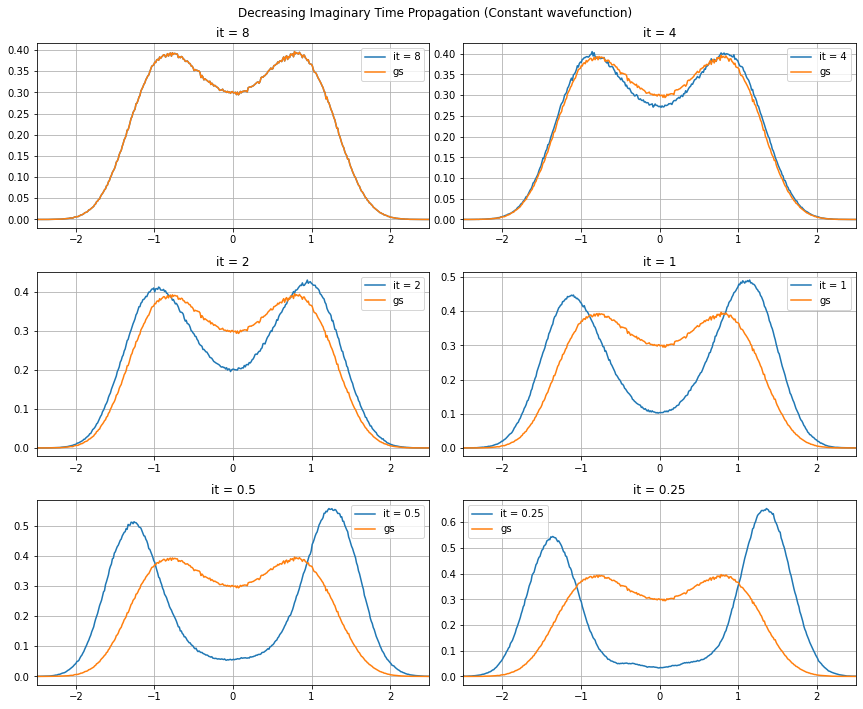

In [127]:
pos_8 = np.loadtxt("./data/PIGS/const_probability.dat", usecols=(1))
pos_4 = np.loadtxt("./data/PIGS/const_probability_4.dat", usecols=(1))
pos_2 = np.loadtxt("./data/PIGS/const_probability_2.dat", usecols=(1))
pos_1 = np.loadtxt("./data/PIGS/const_probability_1.dat", usecols=(1))
pos_05 = np.loadtxt("./data/PIGS/const_probability_05.dat", usecols=(1))
pos_025 = np.loadtxt("./data/PIGS/const_probability_025.dat", usecols=(1))
pos_00 = np.loadtxt("./data/probability.00", usecols=(1))

pos_VMC = np.loadtxt("./data/psi_star/positions.dat", usecols=(1))


fig, ax = plt.subplots(3, 2, figsize=(12, 10))
plt.suptitle("Decreasing Imaginary Time Propagation (Constant wavefunction)")

x = np.linspace(-2.5, 2.5, 400)

plot_pos_hist(pos_00, pos_8, x, "it = 8", ax=ax[0,0])
plot_pos_hist(pos_00, pos_4, x, "it = 4", ax=ax[0,1])
plot_pos_hist(pos_00, pos_2, x, "it = 2", ax=ax[1,0])
plot_pos_hist(pos_00, pos_1, x, "it = 1", ax=ax[1,1])
plot_pos_hist(pos_00, pos_05, x, "it = 0.5", ax=ax[2,0])
plot_pos_hist(pos_00, pos_025, x, "it = 0.25", ax=ax[2,1])

# sns.kdeplot(pos, ax=ax[2,0], label="VMC")  # VARMC
# ax[2,0].legend()
# sns.kdeplot(pos, ax=ax[2,1], label="VMC")  # VARMC
# ax[2,1].legend()

plt.tight_layout()
plt.show()

**Figure: Decreasing imaginary time propagation on PIGS algorithm when starting with a constant wavefunction.** We can see that imaginary time propagation is more important in this case. The algorithm requires more imaginary time to reduce the trial wavefunction to ground state.

# PIMC

Finally, use the PIMC algorithm ($T>0$) to observe how the histogram with the sampled configurations changes by increasing the temperature.

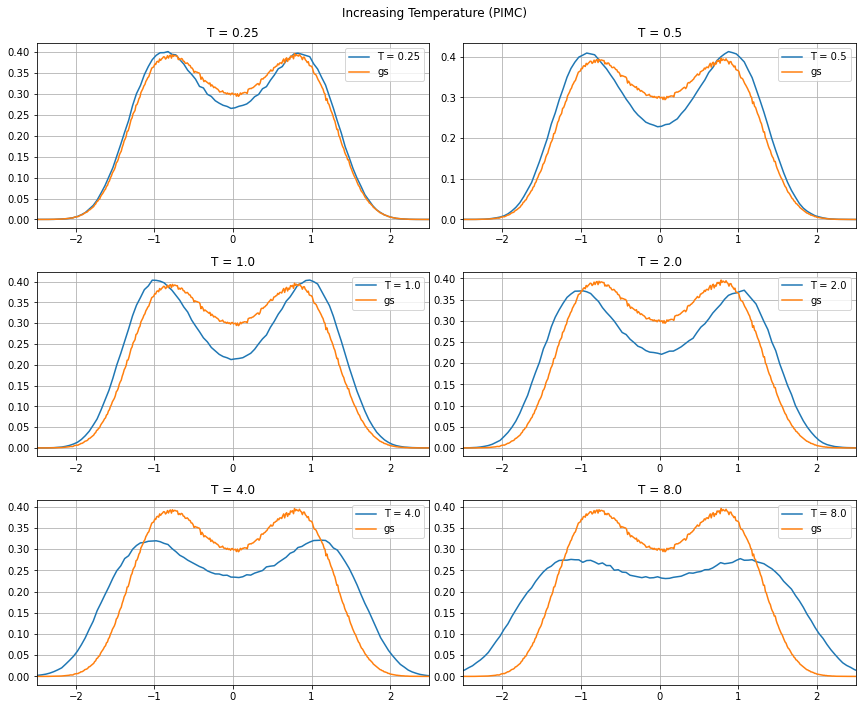

In [131]:
pos_00 = np.loadtxt("./data/probability.00", usecols=(1)) # Ground State
pos_025 = np.loadtxt("./data/PIMC/probability_025.dat", usecols=(1))
pos_05 = np.loadtxt("./data/PIMC/probability_05.dat", usecols=(1))
pos_1 = np.loadtxt("./data/PIMC/probability_1.dat", usecols=(1))
pos_1 = np.loadtxt("./data/PIMC/probability_1.dat", usecols=(1))
pos_2 = np.loadtxt("./data/PIMC/probability_2.dat", usecols=(1))
pos_4 = np.loadtxt("./data/PIMC/probability_4.dat", usecols=(1))
pos_8 = np.loadtxt("./data/PIMC/probability_8.dat", usecols=(1))

pos_VMC = np.loadtxt("./data/psi_star/positions.dat", usecols=(1))

fig, ax = plt.subplots(3, 2, figsize=(12, 10))
plt.suptitle("Increasing Temperature (PIMC)")

x = np.linspace(-10, 10, 400)

plot_pos_hist(pos_00, pos_025, x, "T = 0.25", ax=ax[0, 0])
plot_pos_hist(pos_00, pos_05, x, "T = 0.5", ax=ax[0, 1])
plot_pos_hist(pos_00, pos_1, x, "T = 1.0", ax=ax[1, 0])
plot_pos_hist(pos_00, pos_2, x, "T = 2.0", ax=ax[1, 1])
plot_pos_hist(pos_00, pos_4, x, "T = 4.0", ax=ax[2, 0])
plot_pos_hist(pos_00, pos_8, x, "T = 8.0", ax=ax[2, 1])

plt.tight_layout()
plt.show()

**Figure: Increasing temperature on the PIMC algorithm when starting with VMC wavefunction.** 